In [27]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


df = pd.read_csv('bank-nifty-1m-data.csv')


In [28]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)
df.drop(['Instrument', 'Date', 'Time'], axis=1, inplace=True)

df.dropna(subset=['Close'], inplace=True)
df.ffill(inplace=True)
df.sort_index(inplace=True)

# Ensure numeric types
for col in ['Open', 'High', 'Low', 'Close']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)

print("Data types after cleaning:\n", df.dtypes)
print("Data head:\n", df.head())

Data types after cleaning:
 Open     float64
High     float64
Low      float64
Close    float64
dtype: object
Data head:
                         Open      High       Low     Close
Datetime                                                  
2015-01-09 09:15:00  18845.9  18845.90  18801.70  18801.70
2015-01-09 09:16:00  18801.7  18806.05  18790.20  18794.65
2015-01-09 09:17:00  18796.0  18829.00  18794.65  18827.30
2015-01-09 09:18:00  18827.3  18864.00  18827.30  18862.10
2015-01-09 09:19:00  18862.1  18862.10  18843.55  18849.25


In [29]:
#Technical Indicators
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

def rsi_manual(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # Use EWM for smoothed RSI, closer to standard implementations
    avg_gain = gain.ewm(com=period-1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period-1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI_14'] = rsi_manual(df['Close'], period=14)

def macd_manual(series, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line
df['MACD'], df['MACD_signal'] = macd_manual(df['Close'])

def bbands_manual(series, window=20, num_std_dev=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, rolling_mean, lower_band
df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = bbands_manual(df['Close'])

high_low_range = df['High'] - df['Low']
high_prev_close = np.abs(df['High'] - df['Close'].shift(1))
low_prev_close = np.abs(df['Low'] - df['Close'].shift(1))
true_range = pd.DataFrame({'hl': high_low_range, 'hpc': high_prev_close, 'lpc': low_prev_close}).max(axis=1)
df['ATR_14'] = true_range.ewm(span=14, adjust=False, min_periods=14).mean()


df['Log_Ret_1'] = np.log(df['Close'] / df['Close'].shift(1))
for lag in [1, 2, 3, 5, 10, 20]: # Using a few common lags
    df[f'Lag_Close_{lag}'] = df['Close'].shift(lag)
    df[f'Lag_Log_Ret_{lag}'] = df['Log_Ret_1'].shift(lag)

df['Minute_of_Hour'] = df.index.minute
df['Hour_of_Day'] = df.index.hour
df['Day_of_Week'] = df.index.dayofweek # Monday=0, Sunday=6

df['Volatility_10'] = df['Log_Ret_1'].rolling(window=10).std()

df.dropna(inplace=True)
print("Data head after feature engineering:\n", df.head())

Data head after feature engineering:
                          Open      High       Low     Close     SMA_10  \
Datetime                                                                 
2015-01-09 09:44:00  18763.05  18772.70  18758.50  18771.60  18790.805   
2015-01-09 09:45:00  18774.15  18780.80  18761.50  18768.90  18788.415   
2015-01-09 09:46:00  18768.90  18776.20  18765.10  18776.20  18785.855   
2015-01-09 09:47:00  18776.20  18776.20  18764.75  18764.75  18783.105   
2015-01-09 09:48:00  18768.15  18771.55  18764.25  18766.00  18779.870   

                           SMA_30        EMA_10        EMA_30     RSI_14  \
Datetime                                                                   
2015-01-09 09:44:00  18810.970000  18787.676993  18800.847458  39.467021   
2015-01-09 09:45:00  18809.876667  18784.262994  18798.786332  38.689550   
2015-01-09 09:46:00  18809.261667  18782.796995  18797.329149  42.015428   
2015-01-09 09:47:00  18807.176667  18779.515723  18795.227269  

In [34]:

df['Target_Direction'] = (df['Log_Ret_1'].shift(-1) > 0).astype(int)
df.dropna(subset=['Target_Direction'], inplace=True)

feature_cols = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Target_Direction', 'Log_Ret_1']]
if 'Target_Log_Ret' in feature_cols:
    feature_cols.remove('Target_Log_Ret')


X = df[feature_cols]
y_clf = df['Target_Direction'] # Classification target

# Chronological Train-Test Split
split_ratio = 0.85
split_index = int(len(X) * split_ratio)

X_train_clf, X_test_clf = X[:split_index], X[split_index:]
y_train_clf, y_test_clf = y_clf[:split_index], y_clf[split_index:]

print(f"Classification X_train shape: {X_train_clf.shape}, y_train shape: {y_train_clf.shape}")
print(f"Classification X_test shape: {X_test_clf.shape}, y_test shape: {y_test_clf.shape}")
print(f"Class distribution in training set:\n{y_train_clf.value_counts(normalize=True)}")

Classification X_train shape: (723657, 27), y_train shape: (723657,)
Classification X_test shape: (127705, 27), y_test shape: (127705,)
Class distribution in training set:
Target_Direction
0    0.501898
1    0.498102
Name: proportion, dtype: float64


In [36]:
%pip install optuna
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import TimeSeriesSplit

# --- Basic LightGBM Classifier (before Optuna) ---
lgb_classifier = lgb.LGBMClassifier(
    objective='binary',
    metric='auc', # Using AUC as a common robust metric
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

print("\nTraining Basic LightGBM Classifier...")
lgb_classifier.fit(X_train_clf, y_train_clf,
                   eval_set=[(X_test_clf, y_test_clf)],
                   eval_metric='auc',
                   callbacks=[lgb.early_stopping(100, verbose=True)])

y_pred_clf_proba = lgb_classifier.predict_proba(X_test_clf)[:, 1] # Probabilities for class 1
y_pred_clf = (y_pred_clf_proba > 0.5).astype(int)
print(f"\nBasic LightGBM Classifier Performance:")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.4f}")
print(f"Test AUC: {roc_auc_score(y_test_clf, y_pred_clf_proba):.4f}") # Use probabilities for AUC
print(f"Test F1 Score: {f1_score(y_test_clf, y_pred_clf):.4f}")
print(classification_report(y_test_clf, y_pred_clf))


# --- Optuna Hyperparameter Tuning (Example Structure) ---
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }


    train_val_split_idx = int(len(X_train_clf) * 0.8)
    X_tune_train, X_tune_val = X_train_clf[:train_val_split_idx], X_train_clf[train_val_split_idx:]
    y_tune_train, y_tune_val = y_train_clf[:train_val_split_idx], y_train_clf[train_val_split_idx:]

    model = lgb.LGBMClassifier(**param)
    model.fit(X_tune_train, y_tune_train,
              eval_set=[(X_tune_val, y_tune_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(50, verbose=False)])

    preds_proba = model.predict_proba(X_tune_val)[:, 1]
    auc = roc_auc_score(y_tune_val, preds_proba)
    return auc

print("\nStarting Optuna Hyperparameter Tuning...")
study = optuna.create_study(direction='maximize') # Maximize AUC
study.optimize(objective, n_trials=50) # Run for 50 trials

print("Best trial:")
trial = study.best_trial
print(f"  Value (AUC): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train_clf, y_train_clf,
                eval_set=[(X_test_clf, y_test_clf)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(100, verbose=True)])

y_pred_final_proba = final_model.predict_proba(X_test_clf)[:, 1]
y_pred_final = (y_pred_final_proba > 0.5).astype(int)

print(f"\nOptimized LightGBM Classifier Performance:")
print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred_final):.4f}")
print(f"Test AUC: {roc_auc_score(y_test_clf, y_pred_final_proba):.4f}")
print(f"Test F1 Score: {f1_score(y_test_clf, y_pred_final):.4f}")
print(classification_report(y_test_clf, y_pred_final))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.1 MB/s eta 0:00:00

Training Basic LightGBM Classifier...
[LightGBM] [Info] Number of positive: 360455, number of negative: 363202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 723657, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498102 -> initscore=-0.007592
[LightGBM] [Info] Start training from score -0.007592
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.531348


[I 2025-05-20 21:19:56,037] A new study created in memory with name: no-name-33f10fff-c723-4a88-b662-82b892116139



Basic LightGBM Classifier Performance:
Test Accuracy: 0.5211
Test AUC: 0.5313
Test F1 Score: 0.4285
              precision    recall  f1-score   support

           0       0.52      0.68      0.59     63896
           1       0.53      0.36      0.43     63809

    accuracy                           0.52    127705
   macro avg       0.52      0.52      0.51    127705
weighted avg       0.52      0.52      0.51    127705


Starting Optuna Hyperparameter Tuning...


[I 2025-05-20 21:20:10,925] Trial 0 finished with value: 0.5201949681752598 and parameters: {'n_estimators': 600, 'learning_rate': 0.07813597824707859, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.8418205701522594, 'colsample_bytree': 0.8986977978313795, 'reg_alpha': 0.2749981784218175, 'reg_lambda': 0.5891190581649804}. Best is trial 0 with value: 0.5201949681752598.
[I 2025-05-20 21:20:31,973] Trial 1 finished with value: 0.521441081899283 and parameters: {'n_estimators': 300, 'learning_rate': 0.0349930332590253, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 83, 'subsample': 0.9754131149228623, 'colsample_bytree': 0.8273919214754946, 'reg_alpha': 0.8953371037569803, 'reg_lambda': 0.9984635928914273}. Best is trial 1 with value: 0.521441081899283.
[I 2025-05-20 21:20:54,687] Trial 2 finished with value: 0.5209125061639899 and parameters: {'n_estimators': 500, 'learning_rate': 0.029023664859493516, 'num_leaves': 48, 'max_depth': 11, 'min_child_sa

Best trial:
  Value (AUC): 0.5220821074497244
  Params: 
    n_estimators: 500
    learning_rate: 0.01983837425189316
    num_leaves: 82
    max_depth: 11
    min_child_samples: 69
    subsample: 0.759590440878821
    colsample_bytree: 0.7087740753470612
    reg_alpha: 0.3272067958326672
    reg_lambda: 0.7116075223180062
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.524449

Optimized LightGBM Classifier Performance:
Test Accuracy: 0.5174
Test AUC: 0.5244
Test F1 Score: 0.3841
              precision    recall  f1-score   support

           0       0.51      0.73      0.60     63896
           1       0.53      0.30      0.38     63809

    accuracy                           0.52    127705
   macro avg       0.52      0.52      0.49    127705
weighted avg       0.52      0.52      0.49    127705



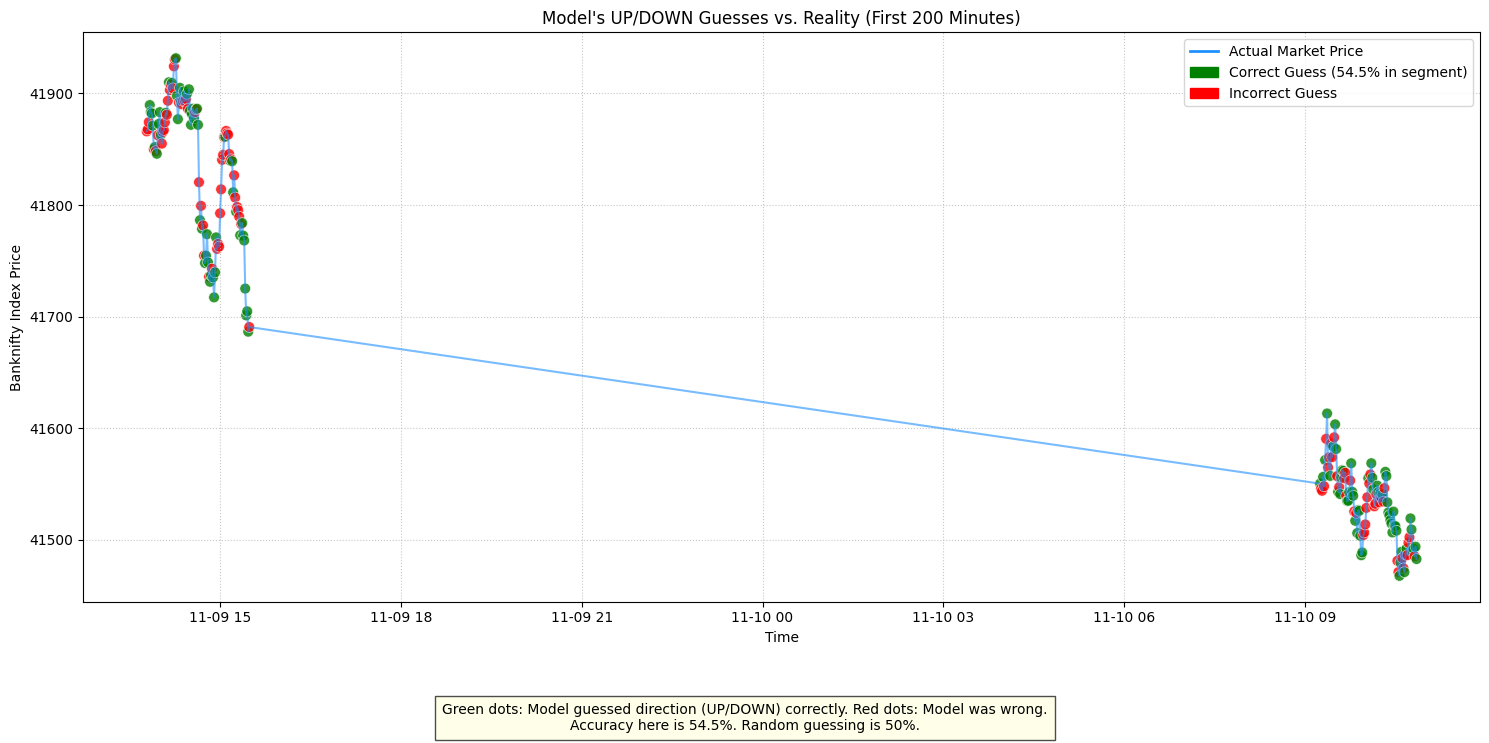

In [42]:

if 'df' in globals() and 'X_test_clf' in globals():
    try:
        actual_close_prices_for_plot = df.loc[X_test_clf.index[:plot_points], 'Close']

        plt.figure(figsize=(15, 7))
        correct_direction_predictions_plot = (y_test_clf.iloc[:plot_points].values == y_pred_final[:plot_points])
        colors = np.where(correct_direction_predictions_plot, 'green', 'red')

        plt.plot(actual_close_prices_for_plot.index, actual_close_prices_for_plot,
                 label='Actual Market Price Path', color='dodgerblue', alpha=0.6, linewidth=1.5)
        plt.scatter(actual_close_prices_for_plot.index, actual_close_prices_for_plot,
                    c=colors, marker='o', s=60, alpha=0.8, edgecolors='w', linewidth=0.5)

        accuracy_subset_plot = np.mean(correct_direction_predictions_plot) * 100
        plt.title(f'Model\'s UP/DOWN Guesses vs. Reality (First {plot_points} Minutes)')
        plt.xlabel('Time')
        plt.ylabel('Banknifty Index Price')

        green_patch = mpatches.Patch(color='green', label=f'Correct Guess ({accuracy_subset_plot:.1f}% in segment)')
        red_patch = mpatches.Patch(color='red', label='Incorrect Guess')
        blue_line = plt.Line2D([0], [0], color='dodgerblue', lw=2, label='Actual Market Price')
        plt.legend(handles=[blue_line, green_patch, red_patch], loc='best')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.figtext(0.5, -0.05,
                    "Green dots: Model guessed direction (UP/DOWN) correctly. Red dots: Model was wrong.\n"
                    f"Accuracy here is {accuracy_subset_plot:.1f}%. Random guessing is 50%.",
                    ha="center", fontsize=10, bbox={"facecolor":"lightyellow", "alpha":0.7, "pad":5})
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()
    except Exception as e:
        print(f"Could not generate hit/miss plot: {e}")
        print("Ensure 'df', 'X_test_clf', 'y_test_clf', 'y_pred_final', and 'plot_points' are correctly defined.")



--- Visualizing Classifier Performance ---



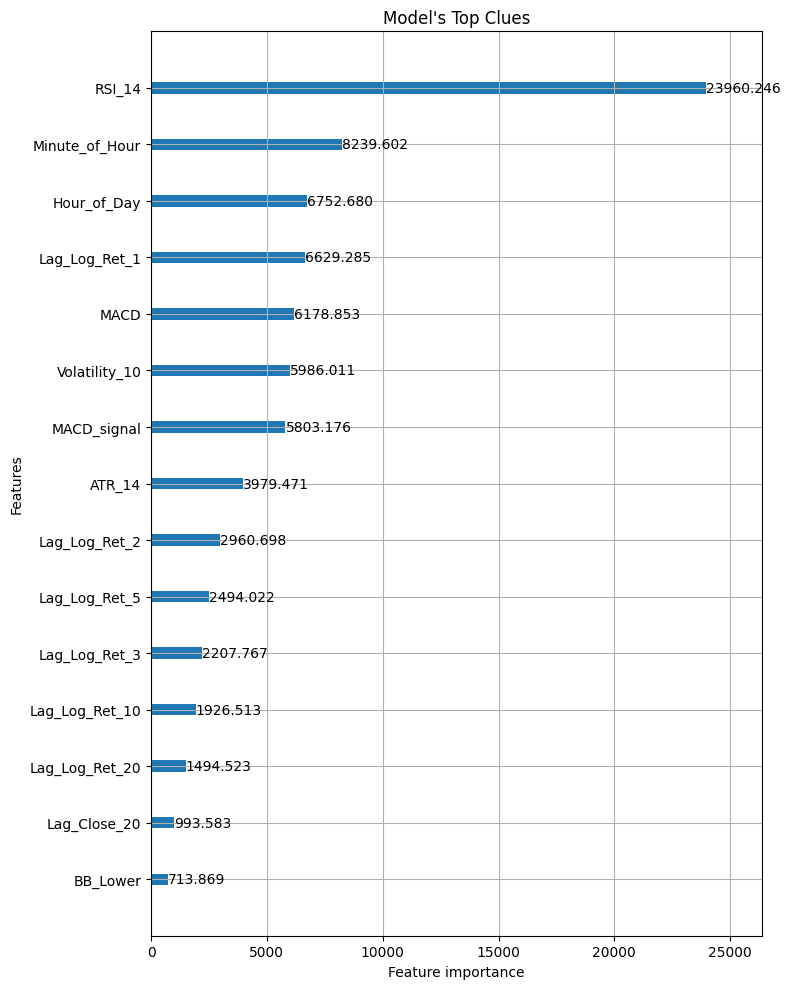

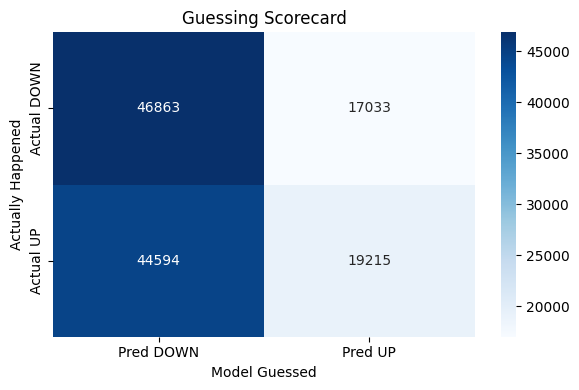

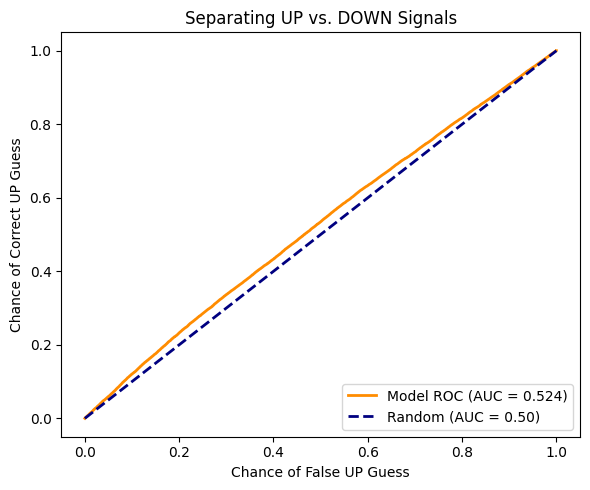

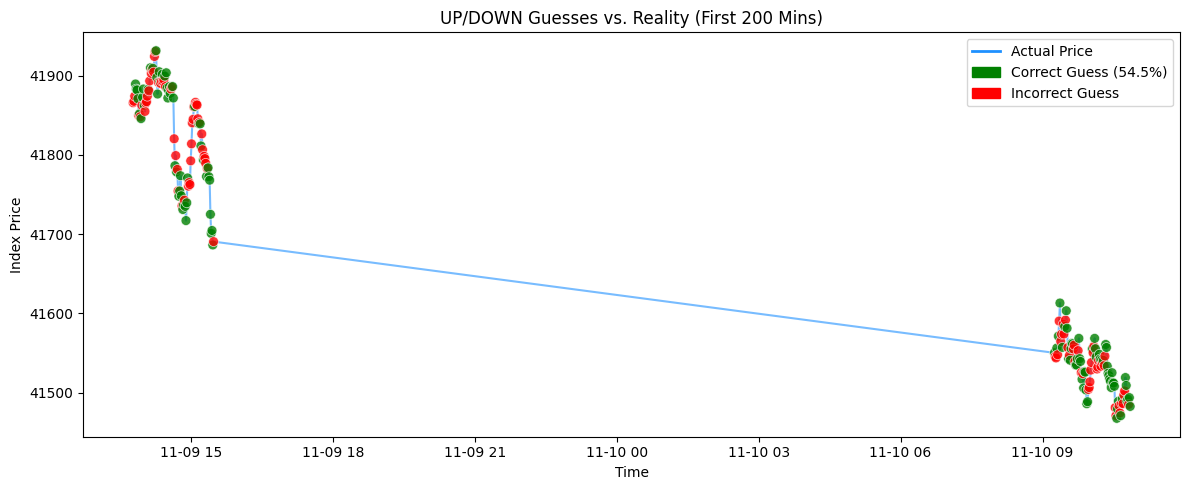

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc as sklearn_auc
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.patches as mpatches

def visualize_classifier_performance(
    final_model, X_test_clf, y_test_clf, y_pred_final_proba, y_pred_final,
    df_full, plot_points=200
):
    print("\n--- Visualizing Classifier Performance ---\n")

    try:
        if hasattr(final_model, '_Booster') and final_model._Booster is not None:
            lgb.plot_importance(final_model, figsize=(8, 10), max_num_features=15, importance_type='gain', title='Model\'s Top Clues')
            plt.tight_layout(); plt.show()
        else:
            print("INFO: Skipping Feature Importance (model not a trained LightGBM or is a dummy).")
    except Exception:
        print("Error plotting feature importance.")

    if y_test_clf is not None and y_pred_final is not None:
        cm = confusion_matrix(y_test_clf, y_pred_final)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred DOWN', 'Pred UP'], yticklabels=['Actual DOWN', 'Actual UP'])
        plt.title('Guessing Scorecard'); plt.xlabel('Model Guessed'); plt.ylabel('Actually Happened')
        plt.tight_layout(); plt.show()
    else:
        print("INFO: Skipping Confusion Matrix (missing y_test_clf or y_pred_final).")

    if y_test_clf is not None and y_pred_final_proba is not None:
        fpr, tpr, _ = roc_curve(y_test_clf, y_pred_final_proba)
        roc_auc = sklearn_auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Model ROC (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
        plt.xlabel('Chance of False UP Guess'); plt.ylabel('Chance of Correct UP Guess'); plt.title('Separating UP vs. DOWN Signals')
        plt.legend(loc="lower right"); plt.tight_layout(); plt.show()
    else:
        print("INFO: Skipping ROC Curve (missing y_test_clf or y_pred_final_proba).")

    if df_full is not None and X_test_clf is not None and y_test_clf is not None and y_pred_final is not None:
        try:
            actual_close_prices_plot = df_full.loc[X_test_clf.index[:plot_points], 'Close']
            if not actual_close_prices_plot.empty:
                plt.figure(figsize=(12, 5))
                correct_direction_plot = (y_test_clf.iloc[:plot_points].values == y_pred_final[:plot_points])
                colors = np.where(correct_direction_plot, 'green', 'red')
                accuracy_subset_plot = np.mean(correct_direction_plot) * 100

                plt.plot(actual_close_prices_plot.index, actual_close_prices_plot, label='Actual Market Price', color='dodgerblue', alpha=0.6, lw=1.5)
                plt.scatter(actual_close_prices_plot.index, actual_close_prices_plot, c=colors, marker='o', s=50, alpha=0.8, ec='w', lw=0.5, zorder=5)

                green_patch = mpatches.Patch(color='green', label=f'Correct Guess ({accuracy_subset_plot:.1f}%)')
                red_patch = mpatches.Patch(color='red', label='Incorrect Guess')
                blue_line = plt.Line2D([0], [0], color='dodgerblue', lw=2, label='Actual Price')
                plt.legend(handles=[blue_line, green_patch, red_patch], loc='best')
                plt.title(f'UP/DOWN Guesses vs. Reality (First {plot_points} Mins)'); plt.xlabel('Time'); plt.ylabel('Index Price')
                plt.tight_layout(); plt.show()
            else:
                print("INFO: Hit/Miss plot skipped (no data for actual_close_prices_plot).")
        except Exception as e:
            print(f"Error in Hit/Miss plot: {e}")
    else:
        print("INFO: Skipping Hit/Miss Dot Plot (missing required data: df_full, X_test_clf, y_test_clf, or y_pred_final).")




if 'final_model' in globals():
    visualize_classifier_performance(
        final_model, X_test_clf, y_test_clf,
        y_pred_final_proba, y_pred_final,
        df, # Pass the full original df
        plot_points=200
    )
else:
    print("Please train your model and prepare test data (final_model, X_test_clf, etc.) before calling visualization.")